Heicoders AI300 Capstone Project

Author: Ng Ru Ying

In [42]:
# !pip install sqlalchemy
# !pip install PyMySQL

--- 
# 1. Connect to database & Load tables

In [ ]:
import pandas as pd
from sqlalchemy import create_engine

# <Credentials omitted>

database_conn = create_engine(f'mysql+pymysql://{USERNAME}:{PASSWORD}@{ENDPOINT}/{DBNAME}', pool_recycle=3600)

# Check if connection is working
df = pd.read_sql('SELECT * FROM account;', database_conn)
df.head()

,account_id,customer_id,tenure_months,num_referrals,has_internet_service,internet_type,has_unlimited_data,has_phone_service,has_multiple_lines,has_premium_tech_support,has_online_security,has_online_backup,has_device_protection,contract_type,paperless_billing,payment_method
0,AAJU-HMJLK,0334-ZFJSR,55,0,Yes,Cable,No,Yes,Yes,Yes,Yes,Yes,No,One Year,Yes,Credit Card
1,AAKY-HUGJV,6235-VDHOM,5,0,Yes,DSL,Yes,No,No,No,No,Yes,No,Month-to-Month,No,Bank Withdrawal
2,AAMB-TJYWC,4006-HKYHO,63,0,Yes,DSL,Yes,Yes,No,Yes,Yes,Yes,Yes,Two Year,Yes,Bank Withdrawal
3,AANL-MWPZF,3258-SYSWS,72,0,Yes,Fiber Optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Two Year,No,Bank Withdrawal
4,AAOS-KANBS,5360-XGYAZ,72,1,Yes,DSL,No,No,No,Yes,Yes,Yes,Yes,Two Year,Yes,Bank Withdrawal


## 1.1 Retrieve all columns from individual tables

In [2]:
# # Individual tables
# table_names = 'account account_usage churn_status city customer'.split(' ')
# df_dict = {}
# for table in table_names:
#     df_dict[table] = pd.read_sql(f'SELECT * FROM {table};', database_conn)
# # Names of tables in the database saved as dictionary keys
# df_dict.keys()

### 1.1.1 Check if account_id and customer_id are unique (prerequisite to combining tables correctly later)

In [3]:
# 1:1 or 1:m relationship between account and customer?
QUERY = '''
SELECT *
FROM account a 
RIGHT JOIN customer cust
    ON cust.customer_id = a.customer_id
'''

df = pd.read_sql(QUERY, database_conn)
df.isna().sum() == 0
# No nulls after join. Therefore every customer has a unique account id.

account_id                  True
customer_id                 True
tenure_months               True
num_referrals               True
has_internet_service        True
internet_type               True
has_unlimited_data          True
has_phone_service           True
has_multiple_lines          True
has_premium_tech_support    True
has_online_security         True
has_online_backup           True
has_device_protection       True
contract_type               True
paperless_billing           True
payment_method              True
customer_id                 True
gender                      True
age                         True
senior_citizen              True
married                     True
num_dependents              True
zip_code                    True
dtype: bool

## 1.2 Combine tables on relevant columns

In [4]:
churn_q2 = '''
SELECT *
FROM account a 
LEFT JOIN churn_status s
    ON s.customer_id = a.customer_id
LEFT JOIN account_usage u
    ON u.account_id = a.account_id
LEFT JOIN customer cust
    ON cust.customer_id = a.customer_id
LEFT JOIN city
    ON city.zip_code = cust.zip_code;
'''

all_df = pd.read_sql(churn_q2, database_conn)
# Remove duplicate columns
all_df = all_df.loc[:, ~all_df.columns.duplicated()]
all_df.status.value_counts()
all_df.nunique()

account_id                       7043
customer_id                      7043
tenure_months                      72
num_referrals                      12
has_internet_service                2
internet_type                       4
has_unlimited_data                  2
has_phone_service                   2
has_multiple_lines                  2
has_premium_tech_support            2
has_online_security                 2
has_online_backup                   2
has_device_protection               2
contract_type                       3
paperless_billing                   2
payment_method                      3
status                              3
churn_label                         3
churn_category                      6
churn_reason                       21
avg_long_distance_fee_monthly    3584
total_long_distance_fee          6068
avg_gb_download_monthly            50
stream_tv                           2
stream_movie                        2
stream_music                        2
total_monthl

In [5]:
# df_dict['all'] = all_df

In [6]:
# original_all_df = all_df.copy()

In [7]:
all_df.describe()

,tenure_months,num_referrals,avg_long_distance_fee_monthly,total_long_distance_fee,avg_gb_download_monthly,total_monthly_fee,total_charges_quarter,total_refunds,age,num_dependents,zip_code,area_id,latitude,longitude,population
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,32.386767,1.951867,22.958954,749.099262,20.515405,64.761692,2280.381264,1.962182,46.509726,0.468692,93486.070567,767.045577,36.197455,-119.756684,22139.603294
std,24.542061,3.001199,15.448113,846.660055,20.418940,30.090047,2266.220462,7.902614,16.750352,0.962802,1856.767505,475.486842,2.468929,2.154425,21152.392837
min,1.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.000000,19.000000,0.000000,90001.000000,1.000000,32.555828,-124.301372,11.000000
25%,9.000000,0.000000,9.210000,70.545000,3.000000,35.500000,400.150000,0.000000,32.000000,0.000000,92101.000000,350.000000,33.990646,-121.788090,2344.000000
50%,29.000000,0.000000,22.890000,401.440000,17.000000,70.350000,1394.550000,0.000000,46.000000,0.000000,93518.000000,741.000000,36.205465,-119.595293,17554.000000
75%,55.000000,3.000000,36.395000,1191.100000,27.000000,89.850000,3786.600000,0.000000,60.000000,0.000000,95329.000000,1182.000000,38.161321,-117.969795,36125.000000
max,72.000000,11.000000,49.990000,3564.720000,85.000000,118.750000,8684.800000,49.790000,80.000000,9.000000,96150.000000,1626.000000,41.962127,-114.192901,105285.000000


---
# 2. Data Cleaning

## 2.1 Replace binary values with 1 and 0, Stayed/Joined to 0, Churned to 1

In [8]:
all_df.replace({'Yes': '1', 'No': '0'}, inplace=True)
all_df['status'].replace({'Stayed': '0', 'Joined': '0', 'Churned': '1'}, inplace=True)

/var/folders/ym/qpjxsh4d7g93c_bgp8rcgjp40000gn/T/ipykernel_13352/2270953360.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df['status'].replace({'Stayed': '0', 'Joined': '0', 'Churned': '1'}, inplace=True)


In [9]:
print(all_df.status.value_counts())
all_df.churn_label.value_counts()

status
0    5174
1    1869
Name: count, dtype: int64


churn_label
0    5174
1    1817
       52
Name: count, dtype: int64

From the above, we can see that the 'churn_label''s 52 missing values are 1 under 'status'. 

Thus, it is likely blank because they are churned, but not within the last month. Going by the definition of the column, we should set the missing values to 0.

## 2.2 Check for nulls and blanks

2.2.1 Null check - none found

In [10]:
# Null check
all_df.isna().sum()

account_id                       0
customer_id                      0
tenure_months                    0
num_referrals                    0
has_internet_service             0
internet_type                    0
has_unlimited_data               0
has_phone_service                0
has_multiple_lines               0
has_premium_tech_support         0
has_online_security              0
has_online_backup                0
has_device_protection            0
contract_type                    0
paperless_billing                0
payment_method                   0
status                           0
churn_label                      0
churn_category                   0
churn_reason                     0
avg_long_distance_fee_monthly    0
total_long_distance_fee          0
avg_gb_download_monthly          0
stream_tv                        0
stream_movie                     0
stream_music                     0
total_monthly_fee                0
total_charges_quarter            0
total_refunds       

2.2.2 Missing value check

In [11]:
# Missing value check
(all_df=='').sum()

account_id                          0
customer_id                         0
tenure_months                       0
num_referrals                       0
has_internet_service                0
internet_type                       0
has_unlimited_data                  0
has_phone_service                   0
has_multiple_lines                  0
has_premium_tech_support            0
has_online_security                 0
has_online_backup                   0
has_device_protection               0
contract_type                       0
paperless_billing                   0
payment_method                      0
status                              0
churn_label                        52
churn_category                   5174
churn_reason                     5174
avg_long_distance_fee_monthly       0
total_long_distance_fee             0
avg_gb_download_monthly             0
stream_tv                           0
stream_movie                        0
stream_music                        0
total_monthl

churn_status table has a big portion of missing values

1. 52 values under churn_label established to set to 0 (churned but not within last month)
2. 5174 category and reason are due to non-churned customers (same 5174 that are not churned). to set to "Unknown"

# 3. Filling missing values

In [12]:
import numpy as np

In [13]:
# Replace empty strings with NaN
all_df.replace('', np.nan, inplace=True)

In [14]:
def fill_nulls(df_list):
    for df in df_list:
        # Following the logic above, churn_label missing values should be 0
        df['churn_label']= df['churn_label'].fillna('0')
        # Churn category and reason are empty because 
        df['churn_category'] = df['churn_category'].fillna('N/A') 
        df['churn_reason'] = df['churn_reason'].fillna('N/A')

fill_nulls([all_df])

all_df.isna().sum()


account_id                       0
customer_id                      0
tenure_months                    0
num_referrals                    0
has_internet_service             0
internet_type                    0
has_unlimited_data               0
has_phone_service                0
has_multiple_lines               0
has_premium_tech_support         0
has_online_security              0
has_online_backup                0
has_device_protection            0
contract_type                    0
paperless_billing                0
payment_method                   0
status                           0
churn_label                      0
churn_category                   0
churn_reason                     0
avg_long_distance_fee_monthly    0
total_long_distance_fee          0
avg_gb_download_monthly          0
stream_tv                        0
stream_movie                     0
stream_music                     0
total_monthly_fee                0
total_charges_quarter            0
total_refunds       

# 4. Data Exploration

In [15]:
import plotly.express as px

def plot_all_cols(df, color_col=None):
    # Plot for each column
    for column in df.columns:
        print(f"Value counts for {column}:\n", df[column].value_counts(), '\n---')

        num_distinct = df[column].nunique()

        # Case 1: Binary column, plot pie or grouped histogram
        if num_distinct == 2:
            if not color_col:
                # Pie chart for binary columns
                fig = px.pie(values=df[column].value_counts(),
                             names=df[column].value_counts().index,
                             title=f'{column} distribution')
            else:
                # Grouped histogram for binary columns and color_col specified
                fig = px.histogram(df, 
                                    x=column, 
                                    color=color_col,
                                    title=f'{column} distribution by {color_col}')
        
        # Case 2: More than 2 distinct values, handle counts per value
        else:
            # Group by and count occurrences
            if color_col:
                if color_col != column:
                    col_counts = df.groupby([column, color_col]).size().reset_index(name='Count')
                else:
                    col_counts = df.groupby([column]).size().reset_index(name='Count')
            else:
                col_counts = df.groupby([column]).size().reset_index(name='Count')

            # Line plot if the column is the same as color_col
            if color_col == column:
                fig = px.line(col_counts, 
                              x=column, 
                              y='Count', 
                              title=f'{column} counts over time', 
                              labels={column: column, 'Count': f'Count of {column}'}, 
                              hover_data={'Count': True})
            else:
                # Scatter plot for larger distinct values
                if num_distinct > 100:
                    fig = px.scatter(col_counts, 
                                     x=column, 
                                     y='Count', 
                                     color=color_col,
                                     title=f'{column} counts by {color_col}', 
                                     labels={column: column, 'Count': f'Count of {column}'}, 
                                     hover_data={'Count': True})
                else:
                    # Scatter chart for smaller distinct values
                    fig = px.line(col_counts, 
                                 x=column, 
                                 y='Count', 
                                 color=color_col, 
                                 title=f'{column} counts by {color_col}', 
                                 labels={column: column, 'Count': f'Count of {column}'}, 
                                 hover_data={'Count': True})

        # Show plot
        fig.show()

    # Return the first few rows of the DataFrame for reference
    return df.head()

In [16]:
all_df.columns

Index(['account_id', 'customer_id', 'tenure_months', 'num_referrals',
       'has_internet_service', 'internet_type', 'has_unlimited_data',
       'has_phone_service', 'has_multiple_lines', 'has_premium_tech_support',
       'has_online_security', 'has_online_backup', 'has_device_protection',
       'contract_type', 'paperless_billing', 'payment_method', 'status',
       'churn_label', 'churn_category', 'churn_reason',
       'avg_long_distance_fee_monthly', 'total_long_distance_fee',
       'avg_gb_download_monthly', 'stream_tv', 'stream_movie', 'stream_music',
       'total_monthly_fee', 'total_charges_quarter', 'total_refunds', 'gender',
       'age', 'senior_citizen', 'married', 'num_dependents', 'zip_code',
       'area_id', 'city', 'latitude', 'longitude', 'population'],
      dtype='object')

In [17]:
plot_all_cols(all_df['''contract_type,
internet_type,
payment_method,
num_referrals,
num_dependents,
tenure_months,
total_monthly_fee,
paperless_billing,
age,
churn_label'''.split(',\n')]
, color_col = 'churn_label'
)
                                        
                                        

Value counts for contract_type:
 contract_type
Month-to-Month    3610
Two Year          1883
One Year          1550
Name: count, dtype: int64 
---


Value counts for internet_type:
 internet_type
Fiber Optic    3035
DSL            1652
None           1526
Cable           830
Name: count, dtype: int64 
---


Value counts for payment_method:
 payment_method
Bank Withdrawal    3909
Credit Card        2749
Mailed Check        385
Name: count, dtype: int64 
---


Value counts for num_referrals:
 num_referrals
0     3821
1     1086
5      264
3      255
7      248
9      238
4      236
2      236
10     223
6      221
8      213
11       2
Name: count, dtype: int64 
---


Value counts for num_dependents:
 num_dependents
0    5416
1     553
2     531
3     517
5      10
4       9
6       3
7       2
9       1
8       1
Name: count, dtype: int64 
---


Value counts for tenure_months:
 tenure_months
1     613
72    362
2     238
3     200
4     176
     ... 
38     59
28     57
39     56
44     51
36     50
Name: count, Length: 72, dtype: int64 
---


Value counts for total_monthly_fee:
 total_monthly_fee
20.05     61
19.85     45
19.90     44
19.95     44
19.70     43
          ..
93.95      1
63.75      1
31.00      1
92.65      1
106.95     1
Name: count, Length: 1585, dtype: int64 
---


Value counts for paperless_billing:
 paperless_billing
1    4171
0    2872
Name: count, dtype: int64 
---


Value counts for age:
 age
42    156
47    153
40    150
44    148
23    146
     ... 
80     66
78     63
66     63
67     61
72     58
Name: count, Length: 62, dtype: int64 
---


Value counts for churn_label:
 churn_label
0    5226
1    1817
Name: count, dtype: int64 
---


,contract_type,internet_type,payment_method,num_referrals,num_dependents,tenure_months,total_monthly_fee,paperless_billing,age,churn_label
0,One Year,Cable,Credit Card,0,0,55,66.05,1,41,0
1,Two Year,DSL,Bank Withdrawal,0,0,63,86.70,1,24,0
2,Two Year,Fiber Optic,Bank Withdrawal,0,0,72,113.80,0,75,0
3,Two Year,None,Bank Withdrawal,4,3,72,24.05,1,59,0
4,Two Year,None,Credit Card,0,0,38,20.30,0,43,0


# 5. Data Transformation

## 5.1 Label Encoding

In [18]:
# From pre-research, internet_type Fiber Optic and payment_method Credit Card showed high feature importance. 
# Manual Label encoding will be done to set 1 to these values, and 0 to the other values for internet_type and payment_Method

all_df_encoded = all_df['''contract_type,
internet_type,
payment_method,
num_referrals,
num_dependents,
tenure_months,
total_monthly_fee,
paperless_billing,
age,
churn_label'''.split(',\n')].copy()

for column in ['internet_type','payment_method','contract_type']:
    print('---\n',all_df_encoded[column].value_counts())

# Transform such that only Fiber Optic or Credit Card is 1
all_df_encoded['internet_type'] = all_df_encoded['internet_type'].apply(lambda x: 1 if x == 'Fiber Optic' else 0)
all_df_encoded['payment_method'] = all_df_encoded['payment_method'].apply(lambda x: 1 if x == 'Credit Card' else 0)

# Use normal Label Encoding for contract_type
from sklearn import preprocessing

#fiber optic itnernet type, payment method credit card
label_encoder = preprocessing.LabelEncoder()
for col in ['contract_type']:#,'internet_type','payment_method']:
    all_df_encoded[col]= label_encoder.fit_transform(all_df_encoded[col])


for column in ['internet_type','payment_method','contract_type']:
    print('---\n',all_df_encoded[column].value_counts())

---
 internet_type
Fiber Optic    3035
DSL            1652
None           1526
Cable           830
Name: count, dtype: int64
---
 payment_method
Bank Withdrawal    3909
Credit Card        2749
Mailed Check        385
Name: count, dtype: int64
---
 contract_type
Month-to-Month    3610
Two Year          1883
One Year          1550
Name: count, dtype: int64
---
 internet_type
0    4008
1    3035
Name: count, dtype: int64
---
 payment_method
0    4294
1    2749
Name: count, dtype: int64
---
 contract_type
0    3610
2    1883
1    1550
Name: count, dtype: int64


# 6. Change to int 

In [19]:
all_df_encoded.dtypes

contract_type          int64
internet_type          int64
payment_method         int64
num_referrals          int64
num_dependents         int64
tenure_months          int64
total_monthly_fee    float64
paperless_billing     object
age                    int64
churn_label           object
dtype: object

In [20]:
def convert_float(df):
    for col in df.columns:
        try:
            if df[col].dtype != 'float64':
                df[col] = df[col].astype(int)
                print(f'converted {col} to int')
        except:
            print(f'unable to convert {col}. retained as {df[col].dtypes}')
            pass
        # except ValueError as e:
        #     print(f"Error in column '{col}': {e}")
        #     non_numeric_values = df[col][~df[col].isnull() & ~df[col].apply(lambda x: isinstance(x, (int, float)))]
        #     if len(non_numeric_values) > 0:
        #         print(f"Column '{col}' contains non-numeric values:")
    print(df.dtypes)
    return df

all_df_encoded = convert_float(all_df_encoded)

converted contract_type to int
converted internet_type to int
converted payment_method to int
converted num_referrals to int
converted num_dependents to int
converted tenure_months to int
converted paperless_billing to int
converted age to int
converted churn_label to int
contract_type          int64
internet_type          int64
payment_method         int64
num_referrals          int64
num_dependents         int64
tenure_months          int64
total_monthly_fee    float64
paperless_billing      int64
age                    int64
churn_label            int64
dtype: object


# 7. Machine Learning
## 7.1 Data preparation

In [21]:
train_df_encoded = all_df_encoded.copy()
train_df_encoded.columns = train_df_encoded.columns.astype(str)

In [22]:
features = '''contract_type,
internet_type,
payment_method,
num_referrals,
num_dependents,
tenure_months,
total_monthly_fee,
paperless_billing,
age,
churn_label'''.split(',\n')

In [23]:
from sklearn.model_selection import train_test_split
def split_data(df: pd.DataFrame,
               y: str = None,
               features = None,
               train:str ='Y'):
    if features == None:
        features = df.columns.tolist()
    features.remove(y)
    X = df[features]
    y = df[y]
    if train=='Y':
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    else:
        X_train, X_test, y_train, y_test = None, None, None, None
    return features, X, y, X_train, X_test, y_train, y_test

features, X, y, X_train, X_test, y_train, y_test = split_data(train_df_encoded.select_dtypes(include=['int','float']),
                                                              y='churn_label',
                                                              features=features,
                                                              train='Y'
                                                              )
X_train.head(5)

,contract_type,internet_type,payment_method,num_referrals,num_dependents,tenure_months,total_monthly_fee,paperless_billing,age
3580,2,0,1,1,0,72,86.65,0,35
2364,0,0,0,0,1,5,46.00,0,56
6813,1,0,1,2,0,26,60.70,0,76
789,0,0,1,0,0,17,25.10,0,48
561,0,1,0,0,0,1,74.25,1,28


## 7.2 Instantiate models


In [24]:
# Model 1: Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg_model = LogisticRegression(random_state=0)

# Model 2: Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
params = {
    'learning_rate': 0.5967511656638482,
    'max_depth': 2,
    # 'max_features': 60,
    'max_leaf_nodes': 381,
    'min_samples_leaf': 9,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.007818203370596966
}
n_features = len(features)
gbc_model = GradientBoostingClassifier(**params, random_state=5, max_features = min(n_features,5))

# Model 3: Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(random_state=5, n_estimators=100)

# Model 4: Cat Boost Classifier
from catboost import CatBoostClassifier
cbc_model = CatBoostClassifier(learning_rate=0.1, random_state=5, verbose=0)

## 7.3 Run models

In [25]:
from sklearn import metrics
import time

model_list = [logreg_model, 
              gbc_model,
              random_forest_model,
              cbc_model,
              ]
model_names = ['LogisticRegression', 
               'GradientBoostingClassifier',
               'RandomForestClassifier',
               'CatBoostClassifier',
               ]

final_result = {'AUC':{},
                'Accuracy':{},
                'model': {}
                } 
i=0
for model in model_list:
    print(i)
    start_time = time.time()
    model_name = model_names[i]
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    auc_score = metrics.roc_auc_score(y_test, y_pred_proba)
    final_result['AUC'][model_name] = auc_score
    if model_name == 'RandomForestClassifier':
        print('Number of Trees used : ', model.n_estimators)
    accuracy_score = metrics.accuracy_score(y_test, y_pred)
    final_result['Accuracy'][model_name]= accuracy_score
    final_result['model'][model_name] = model
    end_time = time.time()
    print('##### Model:', model_name)
    print('AUC:', auc_score)
    print('Accuracy_score:', accuracy_score)
    print('Time taken:', (end_time - start_time)/60, 'mins\n')
    i+=1
    

0
##### Model: LogisticRegression
AUC: 0.8793129059540323
Accuracy_score: 0.8277330809275911
Time taken: 0.002350898583730062 mins

1


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



##### Model: GradientBoostingClassifier
AUC: 0.8962135315215592
Accuracy_score: 0.8438239469947941
Time taken: 0.007796835899353027 mins

2
Number of Trees used :  100
##### Model: RandomForestClassifier
AUC: 0.8899907997728694
Accuracy_score: 0.8414576431613819
Time taken: 0.01576066811879476 mins

3
##### Model: CatBoostClassifier
AUC: 0.8868994994980606
Accuracy_score: 0.8338854708944629
Time taken: 0.05364728371302287 mins



In [26]:
final_result

{'AUC': {'LogisticRegression': 0.8793129059540323,
  'GradientBoostingClassifier': 0.8962135315215592,
  'RandomForestClassifier': 0.8899907997728694,
  'CatBoostClassifier': 0.8868994994980606},
 'Accuracy': {'LogisticRegression': 0.8277330809275911,
  'GradientBoostingClassifier': 0.8438239469947941,
  'RandomForestClassifier': 0.8414576431613819,
  'CatBoostClassifier': 0.8338854708944629},
 'model': {'LogisticRegression': LogisticRegression(random_state=0),
  'GradientBoostingClassifier': GradientBoostingClassifier(learning_rate=0.5967511656638482, max_depth=2,
                             max_features=5, max_leaf_nodes=381,
                             min_samples_leaf=9,
                             min_weight_fraction_leaf=0.007818203370596966,
                             random_state=5),
  'RandomForestClassifier': RandomForestClassifier(random_state=5),
  'CatBoostClassifier': <catboost.core.CatBoostClassifier at 0x12af1f310>}}

# 8. Search CVs
Both GradientBoosting and CatBoost performed well. Optimise both to see if any performs even better than the other.

In [27]:
# Code to optimise using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
def randomize_search(MODEL_NAME, search_params, final_result,
                     X_train=X_train,
                     X_test=X_test,
                     y_test=y_test,
                     ):
    ACCURACY = final_result['Accuracy'][MODEL_NAME]
    AUC = final_result['AUC'][MODEL_NAME]

    # Set up the RandomizedSearchCV
    random_search = RandomizedSearchCV(**search_params)

    # Fit the model
    random_search.fit(X_train, y_train)

    # Print the best parameters and the best score
    print(f"Best parameters found: {random_search.best_params_}")
    print(f"Best cross-validation accuracy: {random_search.best_score_}")

    # Evaluate on the test set
    y_pred = random_search.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    y_pred_proba = random_search.predict_proba(X_test)[:,1]
    auc_score = metrics.roc_auc_score(y_test, y_pred_proba)
    diff_acc = test_accuracy - ACCURACY
    diff_auc = auc_score-AUC

    print(f"""Original accuracy: {round(ACCURACY,5)}    
New accuracy: {round(test_accuracy,5)}
Improved?: {diff_acc>0}
--
Original AUC: {round(AUC,5)}
New AUC: {round(auc_score,5)}
Improved?: {diff_auc>0}
    """)
    result = {'model_name': MODEL_NAME,
              'optimised_model': random_search.best_estimator_,
              'all_result':random_search,
              'best_params':random_search.best_params_,
              'best_cross validation accuracy': random_search.best_score_,
              'y_pred': y_pred,
              'y_pred_proba': y_pred_proba,
              'test auc_score': auc_score,
              'original auc': AUC,
              'test accuracy': test_accuracy,
              'original accuracy': ACCURACY,
              }
    # print(result)
    return result

## 8.1 Optimise GradientBoostingClassifier

In [28]:
# Optimise GradientBoostingClassifier
CHOSEN = 'GradientBoostingClassifier'
gb_model = final_result['model'][CHOSEN]

# Define the hyperparameter search space
param_dist = {
    'learning_rate': [0.1, 0.3, 0.5, 0.6], 
    'max_depth': [2, 3, 4],  
    'max_features': ['sqrt', 'log2', 0.5, 0.6],  
    'max_leaf_nodes': [100, 200, 300, 400], 
    'min_samples_leaf': [5, 7, 9, 10], 
    'min_samples_split': [2, 5, 10],
    'min_weight_fraction_leaf': [0.005, 0.01, 0.02]
}

search_params = {
    'estimator': gb_model,
    'param_distributions': param_dist,
    'n_iter':20,
    'scoring':'roc_auc',  # Optimize for AUC instead of accuracy
    'cv':3,  # 3-fold cross-validation
    'verbose':1,
    'n_jobs':-1,  # Use all available CPU cores
    'random_state':42,
    'return_train_score':True,
    'error_score':'raise'
}

gb_result = randomize_search('GradientBoostingClassifier',
                             search_params,
                             final_result)
# 13.2s

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found: {'min_weight_fraction_leaf': 0.02, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_leaf_nodes': 400, 'max_features': 'log2', 'max_depth': 3, 'learning_rate': 0.1}
Best cross-validation accuracy: 0.9002768062086085
Original accuracy: 0.84382    
New accuracy: 0.84903
Improved?: True
--
Original AUC: 0.89621
New AUC: 0.90445
Improved?: True
    


## 8.2 Optimise CatBoostingClassifier

In [29]:
from sklearn.model_selection import StratifiedKFold
CHOSEN = 'CatBoostClassifier'
cat_model = final_result['model'][CHOSEN]
# Define the parameter distribution for RandomizedSearchCV
param_dist_c = {
    'iterations': [100, 200, 300, 500],  # Number of boosting iterations
    'depth': [4, 5, 6, 7, 8],  # Tree depth
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],  # Fraction of data to use for training each tree
    'colsample_bylevel': [0.7, 0.8, 0.9, 1.0],  # Fraction of features per level
    'l2_leaf_reg': [1, 3, 5, 7, 9],  # L2 regularization term
    'loss_function': ['Logloss']  # Use Logloss for binary classification
}

# Set up RandomizedSearchCV with 3-fold stratified cross-validation
search_params_c = {
    'estimator': cat_model,
    'param_distributions': param_dist_c,
    'n_iter': 20,
    'scoring': 'accuracy',
    'cv': StratifiedKFold(n_splits=3, shuffle=True, random_state=42),  # Stratified k-fold cross-validation
    'verbose': 1,
    'n_jobs': -1,  # Use all available CPU cores
    'random_state': 42,
    'return_train_score': True
}
catboost_result = randomize_search('CatBoostClassifier',
                             search_params_c,
                             final_result)

# 23.3s

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found: {'subsample': 0.8, 'loss_function': 'Logloss', 'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 200, 'depth': 4, 'colsample_bylevel': 0.8}
Best cross-validation accuracy: 0.8456386034487781
Original accuracy: 0.83389    
New accuracy: 0.85376
Improved?: True
--
Original AUC: 0.8869
New AUC: 0.90524
Improved?: True
    


Based on the above, CatBoostClassifier performs a little better. Thus CatBoostClsasifier is chosen.

## 9. Pickle

In [30]:
from pathlib import Path
folder = '../src/model'
full_path = f'{folder}/model.pkl'
Path(folder).mkdir(exist_ok=True)  # Create model/ directory if doesn't exist

In [31]:
import joblib
# Save model
joblib.dump(catboost_result['optimised_model'], full_path)
print(f"Model has been saved successfully.")
catboost_result['optimised_model']

Model has been saved successfully.


In [32]:
pd.Series(catboost_result['y_pred']).value_counts()

# Only binary 0 or 1 predictions were made

0    1652
1     461
Name: count, dtype: int64

# 10. Load Model

In [33]:
model = joblib.load(full_path)
model

# 11. SHAP - feature importance

In [34]:
# !pip install shap

In [35]:
import shap
shap.initjs()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [36]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

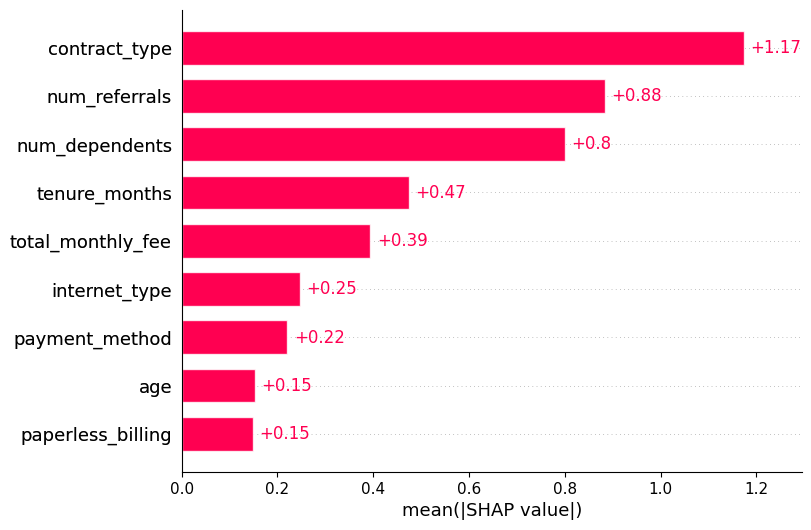

In [37]:
shap.plots.bar(shap_values.abs.mean(0), max_display=20)

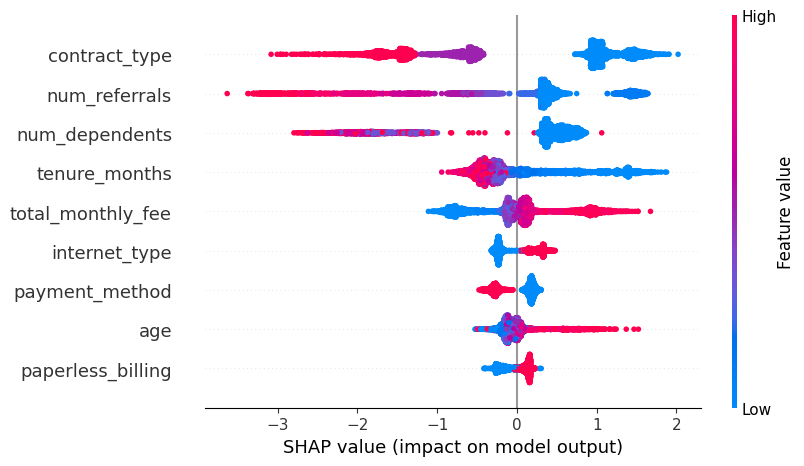

In [38]:
shap.plots.beeswarm(shap_values, max_display=20,)

# 12. Get sample data for webpage

In [39]:
new_data_0 = train_df_encoded[features+['churn_label']][train_df_encoded['churn_label']==0][features].sample(n=1,
                                                                                                             random_state=45)
y_0 = model.predict(new_data_0)

new_data_1 = train_df_encoded[features+['churn_label']][train_df_encoded['churn_label']==1][features].sample(n=1,
                                                                                                             random_state=45)
y_1 = model.predict(new_data_1)
print(y_0, y_1)

[0] [1]


In [40]:
new_data_0.squeeze().to_dict()

{'contract_type': 2.0,
 'internet_type': 0.0,
 'payment_method': 1.0,
 'num_referrals': 9.0,
 'num_dependents': 2.0,
 'tenure_months': 71.0,
 'total_monthly_fee': 19.8,
 'paperless_billing': 0.0,
 'age': 52.0}

In [41]:
new_data_1.squeeze().to_dict()

{'contract_type': 0.0,
 'internet_type': 1.0,
 'payment_method': 0.0,
 'num_referrals': 0.0,
 'num_dependents': 0.0,
 'tenure_months': 51.0,
 'total_monthly_fee': 97.8,
 'paperless_billing': 1.0,
 'age': 70.0}